Brandon Fraune
# CS 6230 | Project 3: Computer Chess Player

## Imports and notebook setup

In [1]:
!pip show matplotlib
!pip install matplotlib==3.4.3
!pip show pandas

Name: matplotlib
Version: 3.4.3
Summary: Python plotting package
Home-page: https://matplotlib.org
Author: John D. Hunter, Michael Droettboom
Author-email: matplotlib-users@python.org
License: PSF
Location: /usr/local/lib/python3.7/dist-packages
Requires: numpy, pyparsing, cycler, pillow, kiwisolver, python-dateutil
Required-by: yellowbrick, seaborn, scikit-image, pycocotools, plotnine, pandas-profiling, mlxtend, mizani, missingno, matplotlib-venn, keras-vis, imgaug, fbprophet, fastai, descartes, daft, arviz
Name: pandas
Version: 1.1.5
Summary: Powerful data structures for data analysis, time series, and statistics
Home-page: https://pandas.pydata.org
Author: None
Author-email: None
License: BSD
Location: /usr/local/lib/python3.7/dist-packages
Requires: python-dateutil, pytz, numpy
Required-by: xarray, vega-datasets, statsmodels, sklearn-pandas, seaborn, pymc3, plotnine, pandas-profiling, pandas-gbq, pandas-datareader, mlxtend, mizani, holoviews, gspread-dataframe, google-colab, fix-ya

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
all2 = pd.read_json('mega-chess-4.json')

## Preparing the data

In [4]:
all2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20090 entries, 0 to 20089
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   game                20090 non-null  int64         
 1   white_player_type   20090 non-null  object        
 2   black_player_type   20090 non-null  object        
 3   game_state          20090 non-null  object        
 4   outcome             20086 non-null  object        
 5   winner              20086 non-null  object        
 6   turn_number         20090 non-null  int64         
 7   plies_made          20090 non-null  int64         
 8   game_start_time     20090 non-null  datetime64[ns]
 9   game_end_time       20090 non-null  datetime64[ns]
 10  game_time_seconds   20090 non-null  float64       
 11  fen                 20090 non-null  object        
 12  white_remaining     20090 non-null  int64         
 13  black_remaining     20090 non-null  int64     

In [5]:
# all.drop(['game','fen', 'game_start_time', 'game_end_time'], axis=1, inplace=True) # Causing Datalore crash???
all2 = all2.drop(['game','fen', 'game_start_time', 'game_end_time'], axis=1)
all2.head()

,white_player_type,black_player_type,game_state,outcome,winner,turn_number,plies_made,game_time_seconds,white_remaining,black_remaining,white_search_depth,white_search_width
0,RANDOM,RANDOM,game over,CHECKMATE,white,30,59,0.025963,12,12,NaN,NaN
1,RANDOM,RANDOM,game over,STALEMATE,draw,113,224,0.102063,2,3,NaN,NaN
2,RANDOM,RANDOM,game over,STALEMATE,draw,104,207,0.102049,5,2,NaN,NaN
3,RANDOM,RANDOM,game over,INSUFFICIENT_MATERIAL,draw,113,224,0.099502,1,2,NaN,NaN
4,RANDOM,RANDOM,game over,INSUFFICIENT_MATERIAL,draw,123,244,0.113052,1,2,NaN,NaN


In [6]:
test_xyz = all2[(all2['white_player_type'] == "RANDOM")]
len(test_xyz)

11100


Dropped some columns that I won't need for analysis.

In [7]:
all2['white_player_type'] = all2['white_player_type']#.astype("category")
all2['black_player_type'] = all2['black_player_type']#.astype("category")
all2['game_state'] = all2['game_state'].astype("category")
all2['outcome'] = all2['outcome'].astype("category")
all2['winner'] = all2['winner'].astype("category")
all2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20090 entries, 0 to 20089
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   white_player_type   20090 non-null  object  
 1   black_player_type   20090 non-null  object  
 2   game_state          20090 non-null  category
 3   outcome             20086 non-null  category
 4   winner              20086 non-null  category
 5   turn_number         20090 non-null  int64   
 6   plies_made          20090 non-null  int64   
 7   game_time_seconds   20090 non-null  float64 
 8   white_remaining     20090 non-null  int64   
 9   black_remaining     20090 non-null  int64   
 10  white_search_depth  8990 non-null   float64 
 11  white_search_width  8990 non-null   float64 
dtypes: category(3), float64(3), int64(4), object(2)
memory usage: 1.4+ MB


In [8]:
unfinished = all2[(all2['game_state'] != 'game over')]
finished = all2[(all2['game_state'] == 'game over')]

svr = finished[(finished['white_player_type'] == 'SEARCH') & (finished['black_player_type'] == 'RANDOM')]
rvr = finished[(finished['white_player_type'] == 'RANDOM') & (finished['black_player_type'] == 'RANDOM')]

There were several games that were unfinished. Ignoring these for now, but it presents an interesting issue with the AI. Also splitting out Random vs Random (rvr) games from Search vs Random (svr).

In [9]:
svr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8986 entries, 100 to 20089
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   white_player_type   8986 non-null   object  
 1   black_player_type   8986 non-null   object  
 2   game_state          8986 non-null   category
 3   outcome             8986 non-null   category
 4   winner              8986 non-null   category
 5   turn_number         8986 non-null   int64   
 6   plies_made          8986 non-null   int64   
 7   game_time_seconds   8986 non-null   float64 
 8   white_remaining     8986 non-null   int64   
 9   black_remaining     8986 non-null   int64   
 10  white_search_depth  8986 non-null   float64 
 11  white_search_width  8986 non-null   float64 
dtypes: category(3), float64(3), int64(4), object(2)
memory usage: 728.7+ KB


In [10]:
rvr = rvr.drop(['white_search_depth', 'white_search_width'], axis=1)
rvr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11100 entries, 0 to 19641
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   white_player_type  11100 non-null  object  
 1   black_player_type  11100 non-null  object  
 2   game_state         11100 non-null  category
 3   outcome            11100 non-null  category
 4   winner             11100 non-null  category
 5   turn_number        11100 non-null  int64   
 6   plies_made         11100 non-null  int64   
 7   game_time_seconds  11100 non-null  float64 
 8   white_remaining    11100 non-null  int64   
 9   black_remaining    11100 non-null  int64   
dtypes: category(3), float64(1), int64(4), object(2)
memory usage: 726.7+ KB


## Visualizing the games

### Game time to complete

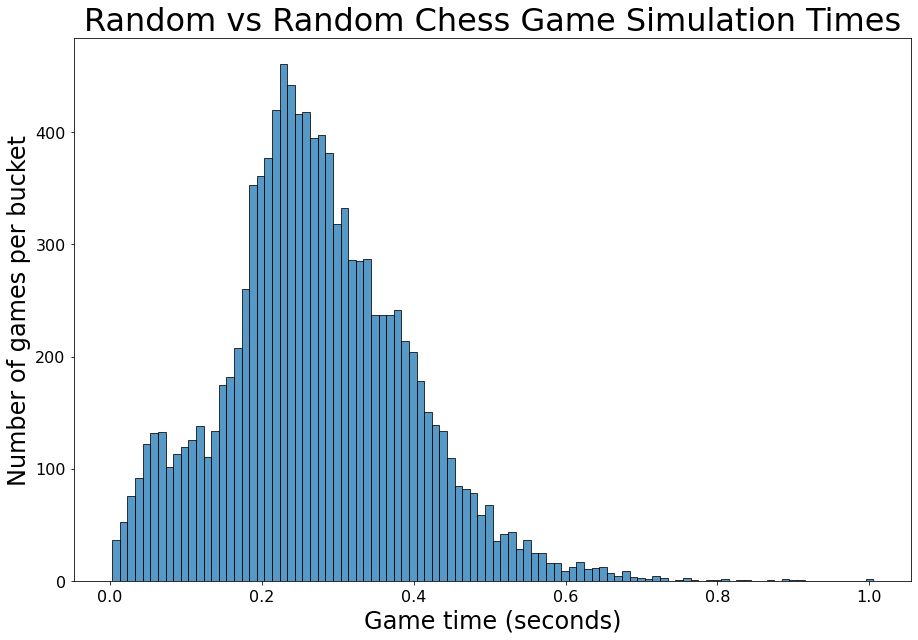

In [11]:
plt.figure(figsize=(15, 10))
sns.histplot(data=rvr['game_time_seconds'], bins=100)
plt.title('Random vs Random Chess Game Simulation Times', fontsize=32)
plt.xlabel('Game time (seconds)', fontsize=24)
plt.ylabel('Number of games per bucket', fontsize=24)
plt.tick_params(axis='both', labelsize=16, pad=5)
plt.show()

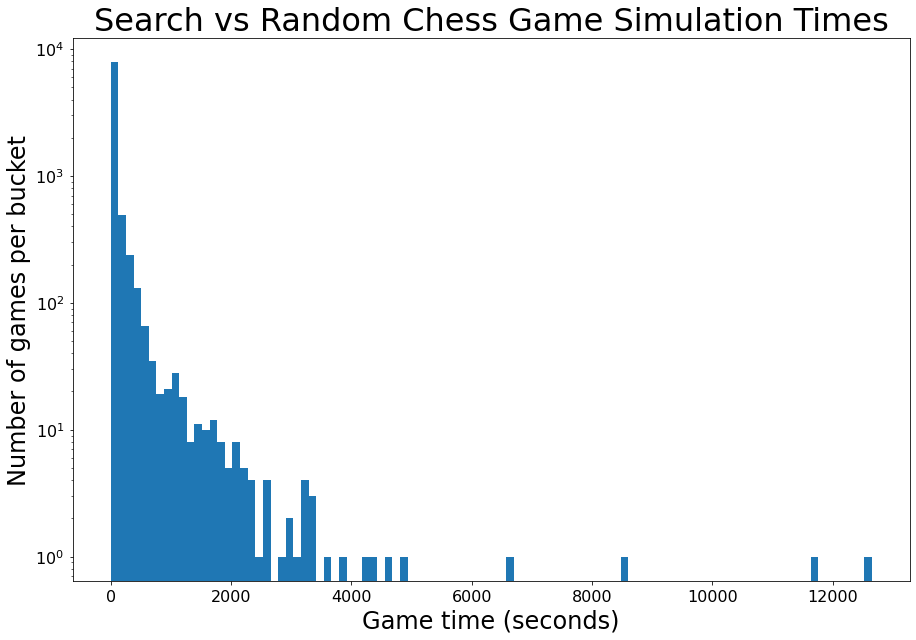

In [12]:
plt.figure(figsize=(15, 10))
plt.hist(svr['game_time_seconds'], bins=100, log=True)
plt.title('Search vs Random Chess Game Simulation Times', fontsize=32)
plt.xlabel('Game time (seconds)', fontsize=24)
plt.ylabel('Number of games per bucket', fontsize=24)
plt.tick_params(axis='both', labelsize=16, pad=5)
plt.show()

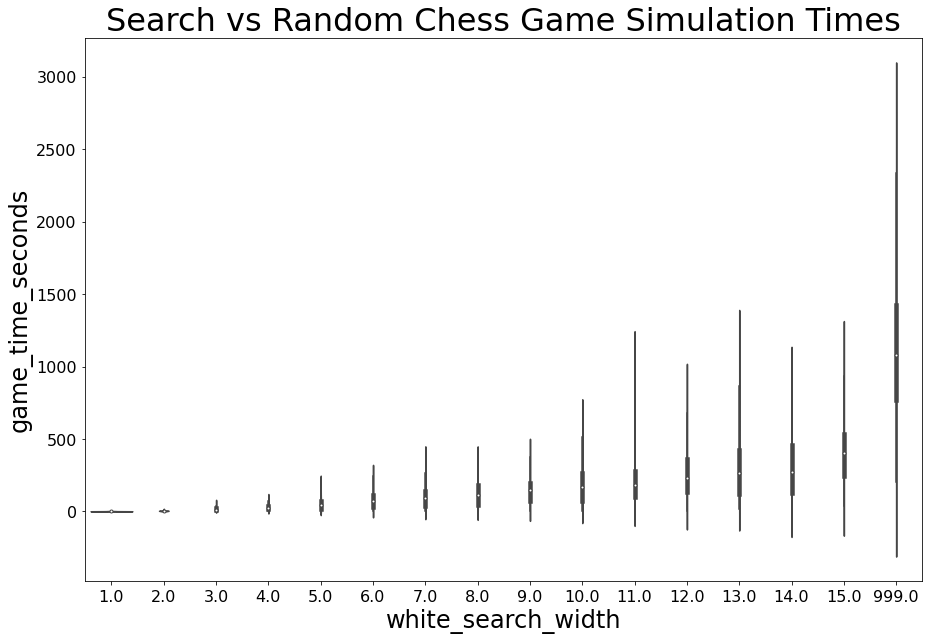

In [13]:
width_3 = svr[(svr['white_search_depth'] == 3)]
plt.figure(figsize=(15, 10))
sns.violinplot(x='white_search_width', y='game_time_seconds', data=width_3)
plt.title('Search vs Random Chess Game Simulation Times', fontsize=32)
plt.xlabel('white_search_width', fontsize=24)
plt.ylabel('game_time_seconds', fontsize=24)
plt.tick_params(axis='both', labelsize=16, pad=5)
plt.show()
# plt.violinplot(rvr['game_time'])
# sns.violinplot(x="plies_made", y="game_time_seconds", data=rvr)

### other

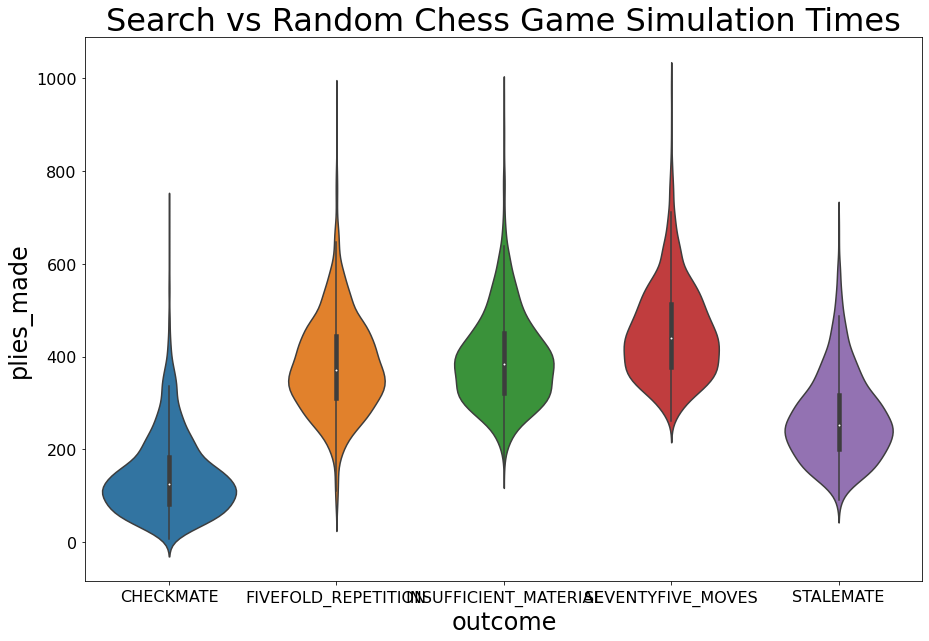

In [14]:
plt.figure(figsize=(15, 10))
sns.violinplot(x='outcome', y='plies_made', data=svr)
plt.title('Search vs Random Chess Game Simulation Times', fontsize=32)
plt.xlabel('outcome', fontsize=24)
plt.ylabel('plies_made', fontsize=24)
plt.tick_params(axis='both', labelsize=16, pad=5)
plt.show()

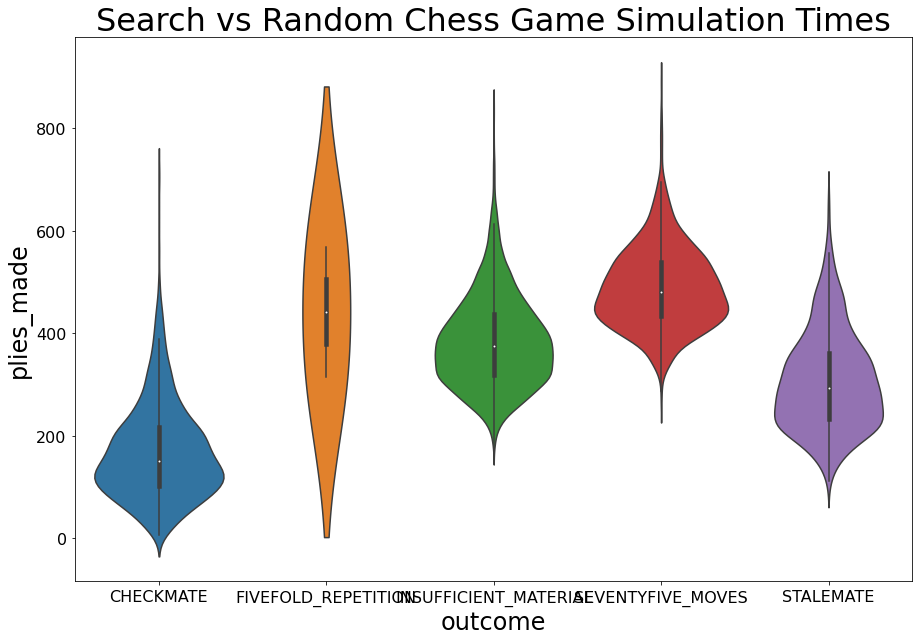

In [15]:
plt.figure(figsize=(15, 10))
sns.violinplot(x='outcome', y='plies_made', data=rvr)
plt.title('Search vs Random Chess Game Simulation Times', fontsize=32)
plt.xlabel('outcome', fontsize=24)
plt.ylabel('plies_made', fontsize=24)
plt.tick_params(axis='both', labelsize=16, pad=5)
plt.show()

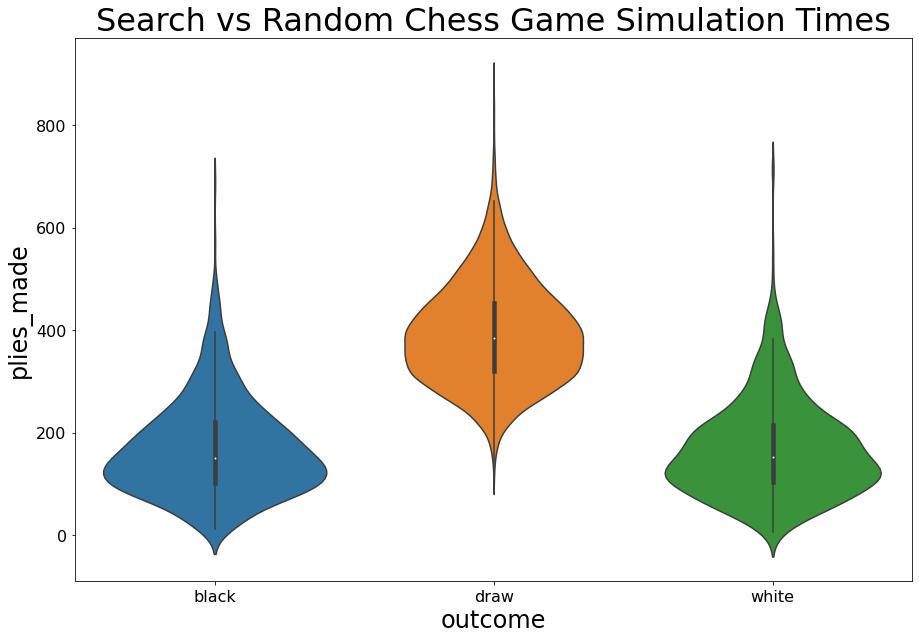

In [16]:
plt.figure(figsize=(15, 10))
sns.violinplot(x='winner', y='plies_made', data=rvr)
plt.title('Search vs Random Chess Game Simulation Times', fontsize=32)
plt.xlabel('outcome', fontsize=24)
plt.ylabel('plies_made', fontsize=24)
plt.tick_params(axis='both', labelsize=16, pad=5)
plt.show()

### ?

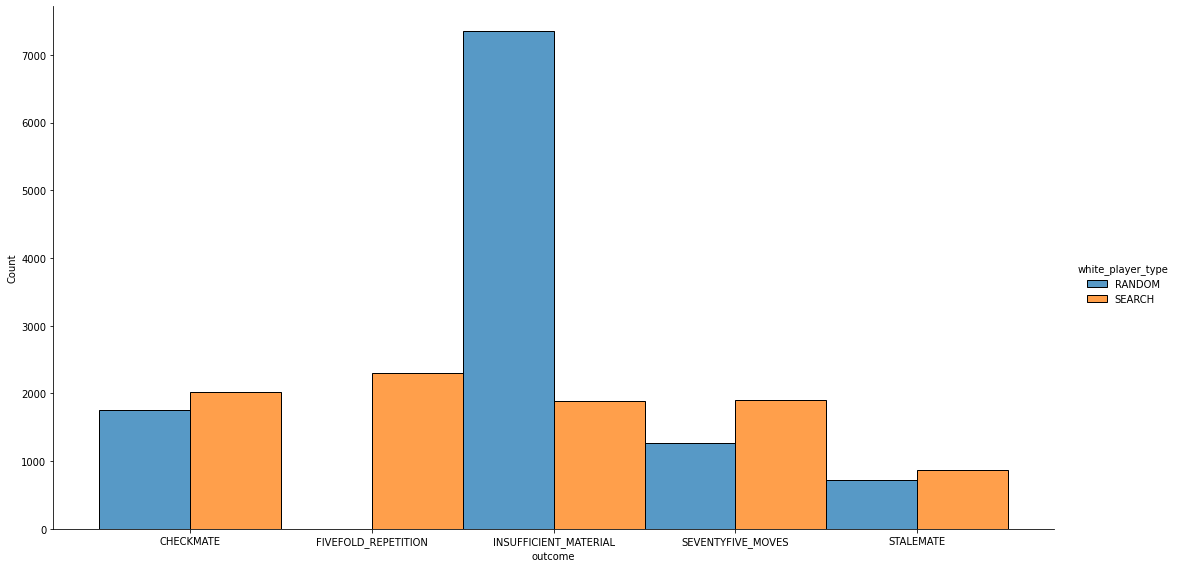

In [17]:
sns.displot(finished, x="outcome", hue="white_player_type", multiple="dodge", height=8, aspect=15/8)

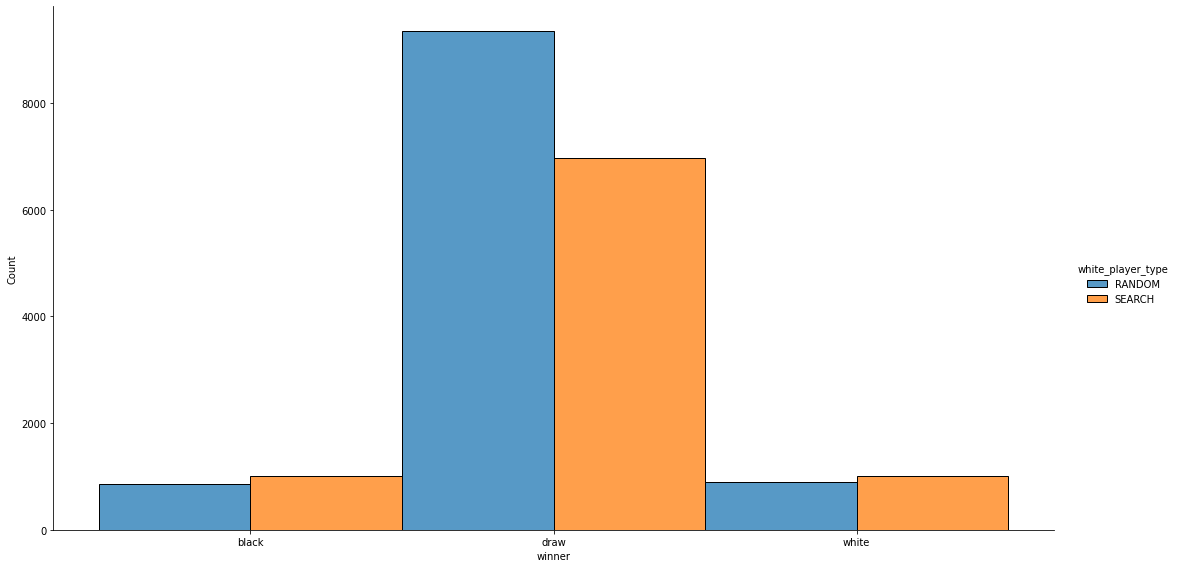

In [18]:
sns.displot(finished, x="winner", hue="white_player_type", multiple="dodge", height=8, aspect=15/8)

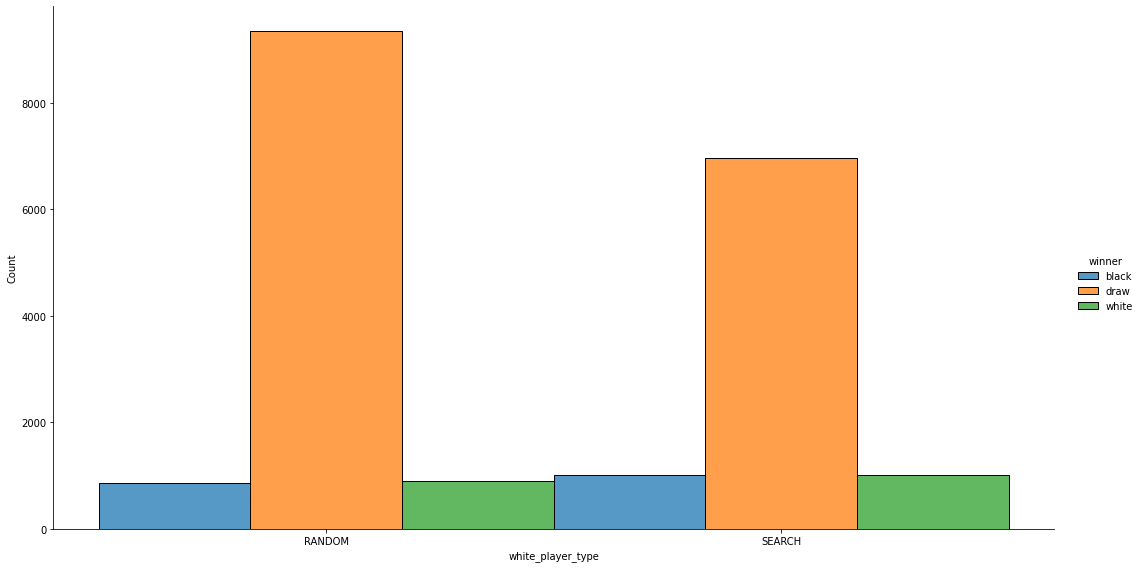

In [19]:
sns.displot(finished, x="white_player_type", hue="winner", multiple="dodge", height=8, aspect=15/8)

In [20]:
rvr_white_wins = rvr[(rvr['winner'] == 'white')]
rvr_draws = rvr[(rvr['winner'] == 'draw')]
rvr_black_wins = rvr[(rvr['winner'] == 'black')]
rvr_white_win_rate = len(rvr_white_wins) / len(rvr)
rvr_draw_rate = len(rvr_draws) / len(rvr)
rvr_black_win_rate = len(rvr_black_wins) / len(rvr)

svr_white_wins = svr[(svr['winner'] == 'white')]
svr_draws = svr[(svr['winner'] == 'draw')]
svr_black_wins = svr[(svr['winner'] == 'black')]
svr_white_win_rate = len(svr_white_wins) / len(svr)
svr_draw_rate = len(svr_draws) / len(svr)
svr_black_win_rate = len(svr_black_wins) / len(svr)

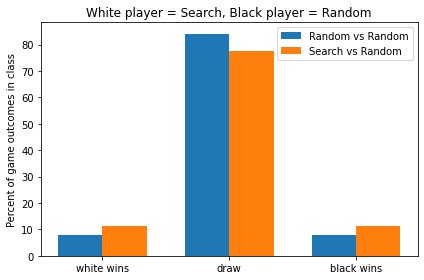

In [21]:
labels = ['white wins', 'draw', 'black wins']
rvr_means = [(100*rvr_white_win_rate), (100*rvr_draw_rate), (100*rvr_black_win_rate)]
svr_means = [(100*svr_white_win_rate), (100*svr_draw_rate), (100*svr_black_win_rate)]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, rvr_means, width, label='Random vs Random')
rects2 = ax.bar(x + width/2, svr_means, width, label='Search vs Random')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percent of game outcomes in class')
ax.set_title('White player = Search, Black player = Random')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# ax.bar_label(rects1, padding=3) # fails in colab
# ax.bar_label(rects2, padding=3) # fails in colab

fig.tight_layout()

plt.show()

This plot is misleading, since SvR games with a search depth of 1 are effectively also RvR.

In [22]:
labels = []
white_win_rates = []
draw_rates = []
black_win_rates = []

white_wins_rvr = rvr[(rvr['winner'] == 'white')]
draws_rvr = rvr[(rvr['winner'] == 'draw')]
black_wins_rvr = rvr[(rvr['winner'] == 'black')]
white_wins_rvr_rate = len(white_wins_rvr) / len(rvr)
draws_rvr_rate = len(draws_rvr) / len(rvr)
black_wins_rvr_rate = len(black_wins_rvr) / len(rvr)
labels.append('RvR')
white_win_rates.append(100*white_wins_rvr_rate)
draw_rates.append(100*draws_rvr_rate)
black_win_rates = [100*black_wins_rvr_rate]


# in SVR
for depth in svr['white_search_depth'].unique():
  depth = int(depth)
  svr_d = svr[(svr['white_search_depth'] == depth)]
  for width in svr_d['white_search_width'].unique():
    width = int(width)
    svr_d_w = svr_d[(svr_d['white_search_width'] == width)]

    white_wins_svr_d_w = svr_d_w[(svr_d_w['winner'] == 'white')]
    draws_svr_d_w = svr_d_w[(svr_d_w['winner'] == 'draw')]
    black_wins_svr_d_w = svr_d_w[(svr_d_w['winner'] == 'black')]
    white_wins_svr_d_w_rate = len(white_wins_svr_d_w) / len(svr_d_w)
    draws_svr_d_w_rate = len(draws_svr_d_w) / len(svr_d_w)
    black_wins_svr_d_w_rate = len(black_wins_svr_d_w) / len(svr_d_w)
    labels.append(f'SvR d{depth} w{width}')
    white_win_rates.append(100*white_wins_svr_d_w_rate)
    draw_rates.append(100*draws_svr_d_w_rate)
    black_win_rates.append(100*black_wins_svr_d_w_rate)

In [23]:
print(len(white_win_rates))
print(len(draw_rates))
print(len(black_win_rates))

print(white_win_rates[70])

74
74
74
14.000000000000002


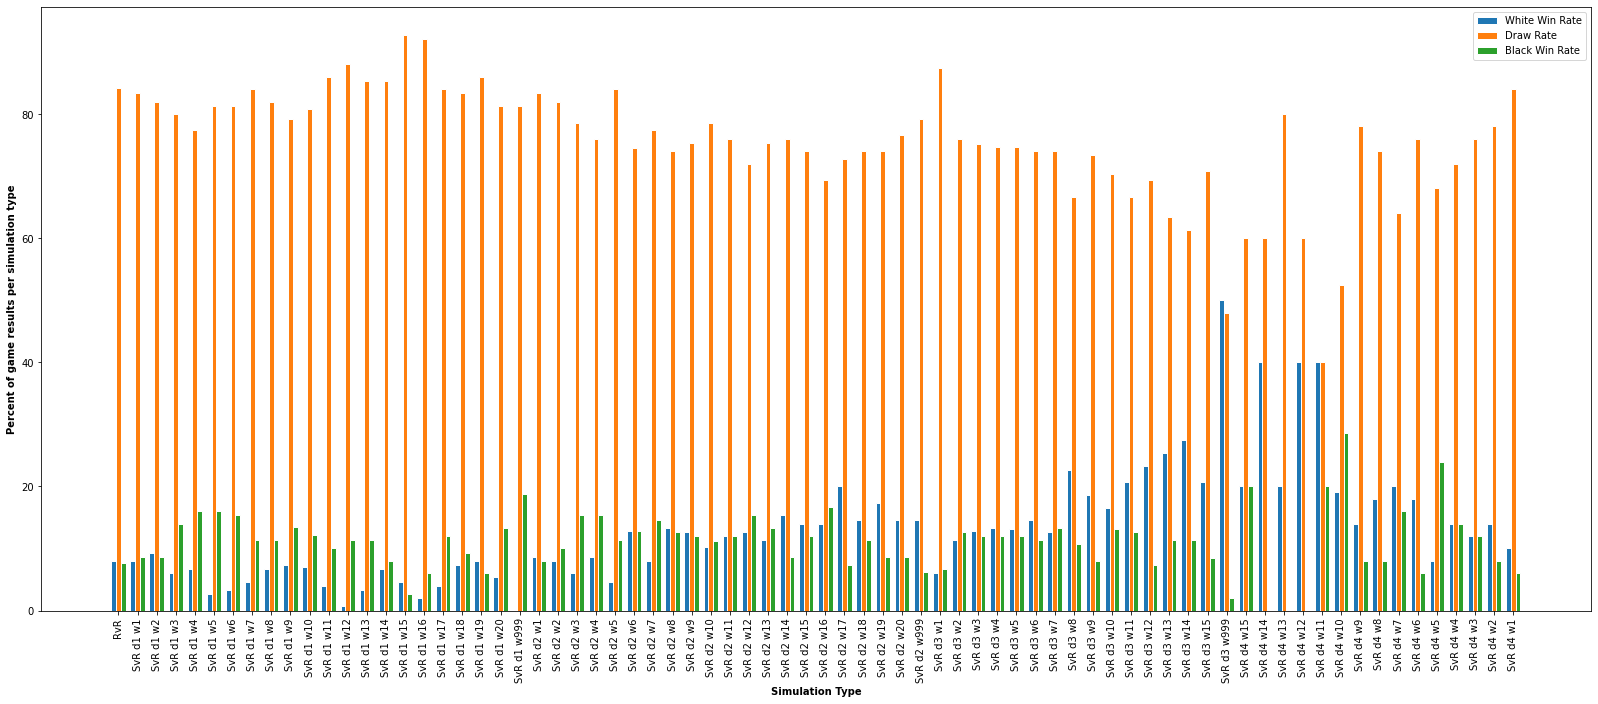

In [24]:
px = 1/plt.rcParams['figure.dpi']  # pixel in inches
plt.subplots(figsize=(2000*px, 800*px))

# set width of bars
barWidth = 0.25
 
# set heights of bars
bars1 = white_win_rates
bars2 = draw_rates
bars3 = black_win_rates
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, bars1, width=barWidth, edgecolor='white', label='White Win Rate')
plt.bar(r2, bars2, width=barWidth, edgecolor='white', label='Draw Rate')
plt.bar(r3, bars3, width=barWidth, edgecolor='white', label='Black Win Rate')
 
# Add xticks on the middle of the group bars
plt.xlabel('Simulation Type', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], labels, rotation=90)
plt.ylabel('Percent of game results per simulation type', fontweight='bold')

# Create legend & Show graphic
plt.legend()
plt.show()

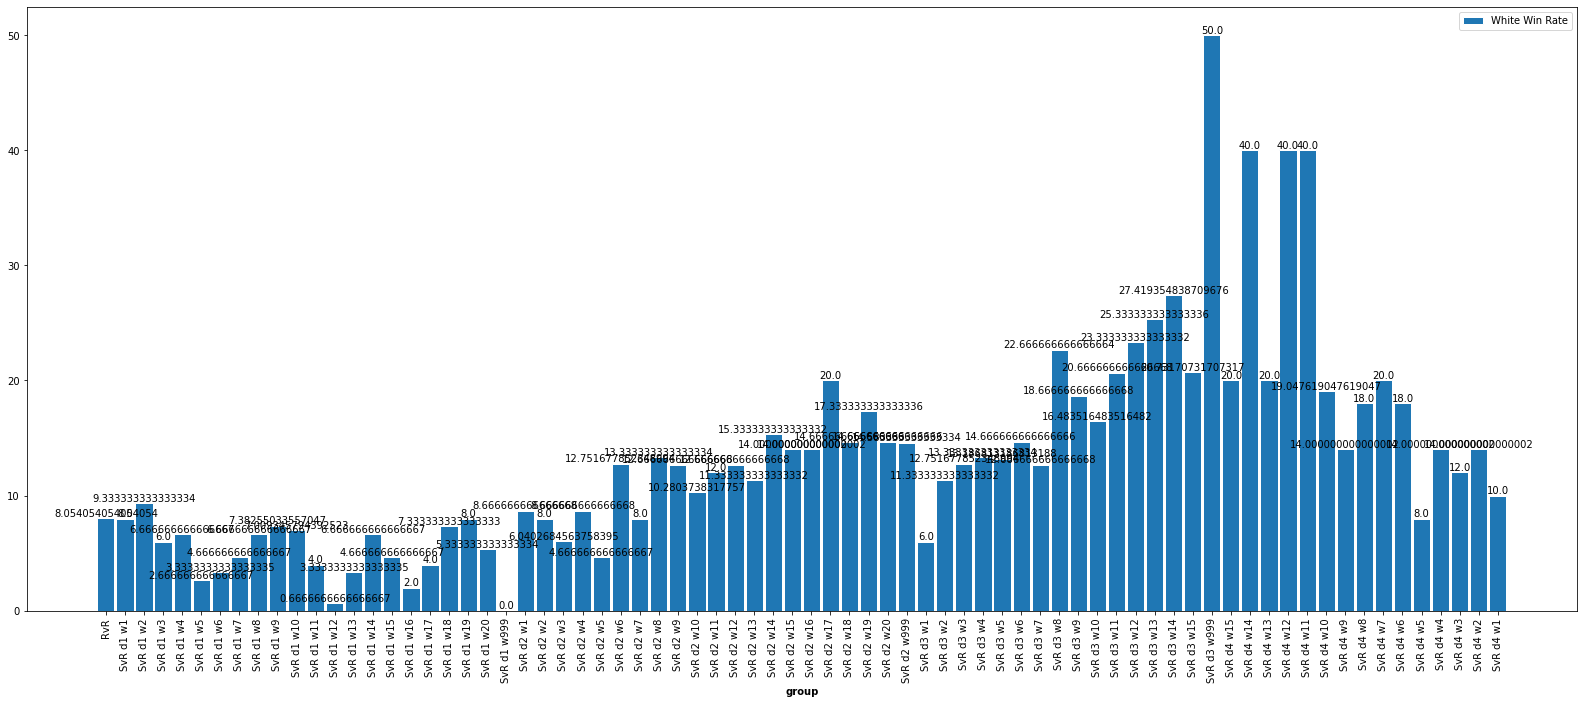

In [25]:
px = 1/plt.rcParams['figure.dpi']  # pixel in inches
fig, ax = plt.subplots(figsize=(2000*px, 800*px))

# set width of bars
barWidth = 0.9
 
# set heights of bars
bars1 = white_win_rates
bars2 = draw_rates
bars3 = black_win_rates
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
rects = ax.bar(r2, bars1, width=barWidth, edgecolor='white', label='White Win Rate')
 
# Add xticks on the middle of the group bars
plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], labels, rotation=90)

# ax.bar_label(bars1, padding=3)
ax.bar_label(rects, bars1, label_type='edge')

# Create legend & Show graphic
plt.legend()
plt.show()

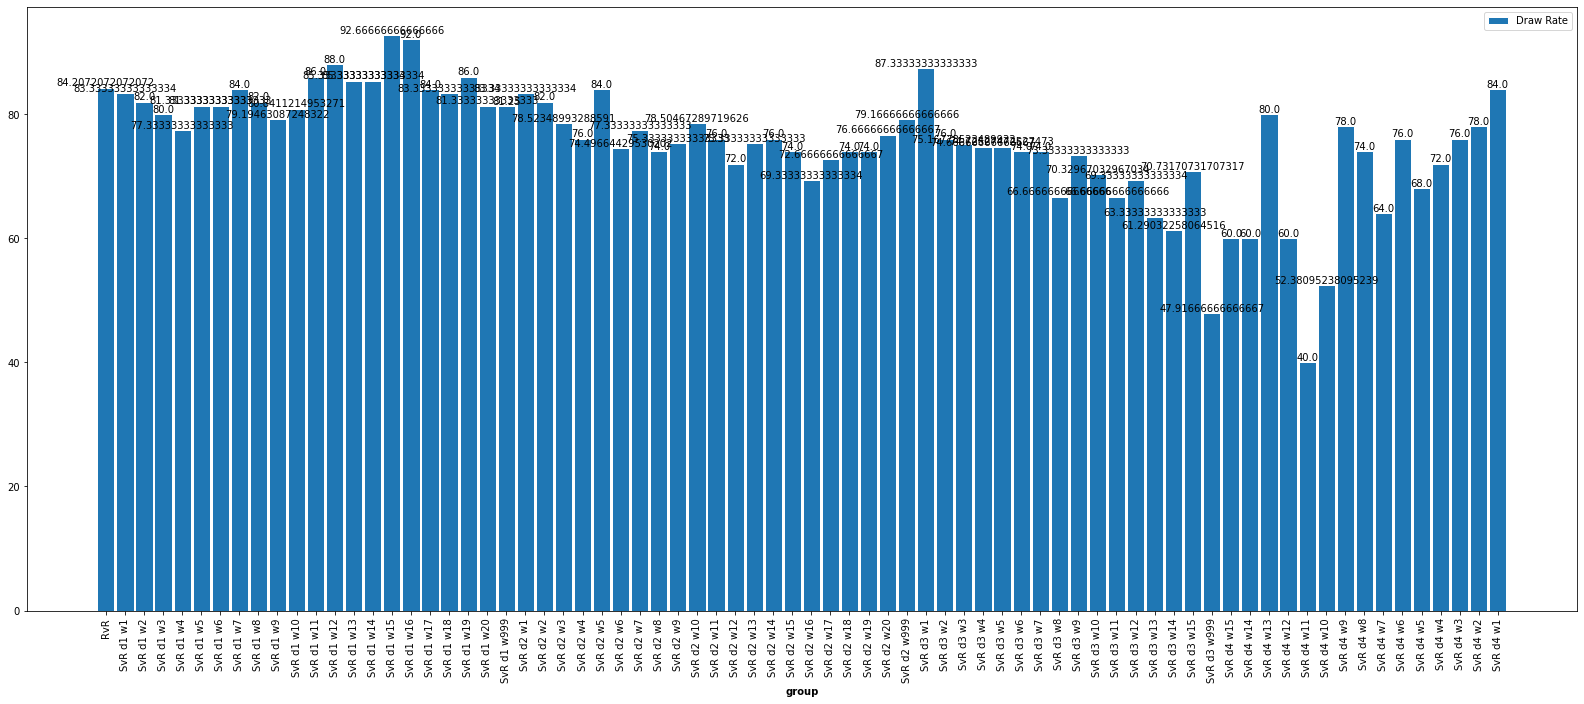

In [26]:
px = 1/plt.rcParams['figure.dpi']  # pixel in inches
fig, ax = plt.subplots(figsize=(2000*px, 800*px))

# set width of bars
barWidth = 0.9
 
# set heights of bars
bars1 = white_win_rates
bars2 = draw_rates
bars3 = black_win_rates
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
rects = ax.bar(r2, bars2, width=barWidth, edgecolor='white', label='Draw Rate')
 
# Add xticks on the middle of the group bars
plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars2))], labels, rotation=90)

ax.bar_label(rects, bars2, label_type='edge')

# Create legend & Show graphic
plt.legend()
plt.show()

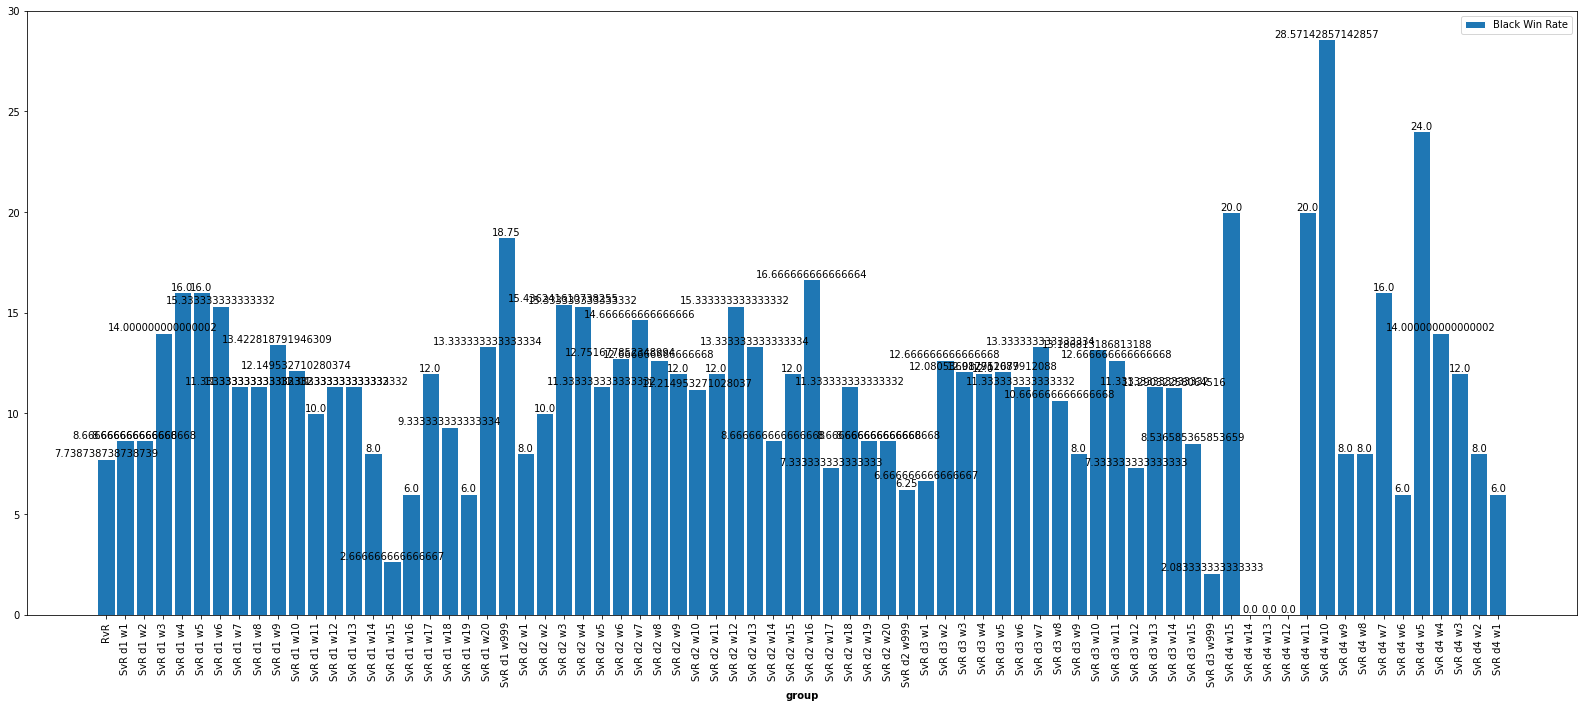

In [27]:
px = 1/plt.rcParams['figure.dpi']  # pixel in inches
fig, ax = plt.subplots(figsize=(2000*px, 800*px))

# set width of bars
barWidth = 0.9
 
# set heights of bars
bars1 = white_win_rates
bars2 = draw_rates
bars3 = black_win_rates
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
rects = ax.bar(r2, bars3, width=barWidth, edgecolor='white', label='Black Win Rate')
 
# Add xticks on the middle of the group bars
plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars3))], labels, rotation=90)

ax.bar_label(rects, bars3, label_type='edge')

# Create legend & Show graphic
plt.legend()
plt.show()

In [28]:
my_ai = svr[(svr['winner'] == 'white') & (svr['white_search_depth'] == 3) & (svr['white_search_width'] == 999)]
print(len(my_ai))
idx = my_ai['game_time_seconds'].argmax()
print(idx)
longest = my_ai.iloc[[idx]]
longest.head()

24
22


,white_player_type,black_player_type,game_state,outcome,winner,turn_number,plies_made,game_time_seconds,white_remaining,black_remaining,white_search_depth,white_search_width
19845,SEARCH,RANDOM,game over,CHECKMATE,white,73,145,2582.276271,13,4,3.0,999.0


In [29]:
idx = my_ai['game_time_seconds'].argmin()
print(idx)
shortest = my_ai.iloc[[idx]]
shortest.head()

17


,white_player_type,black_player_type,game_state,outcome,winner,turn_number,plies_made,game_time_seconds,white_remaining,black_remaining,white_search_depth,white_search_width
19837,SEARCH,RANDOM,game over,CHECKMATE,white,12,23,206.488853,17,11,3.0,999.0


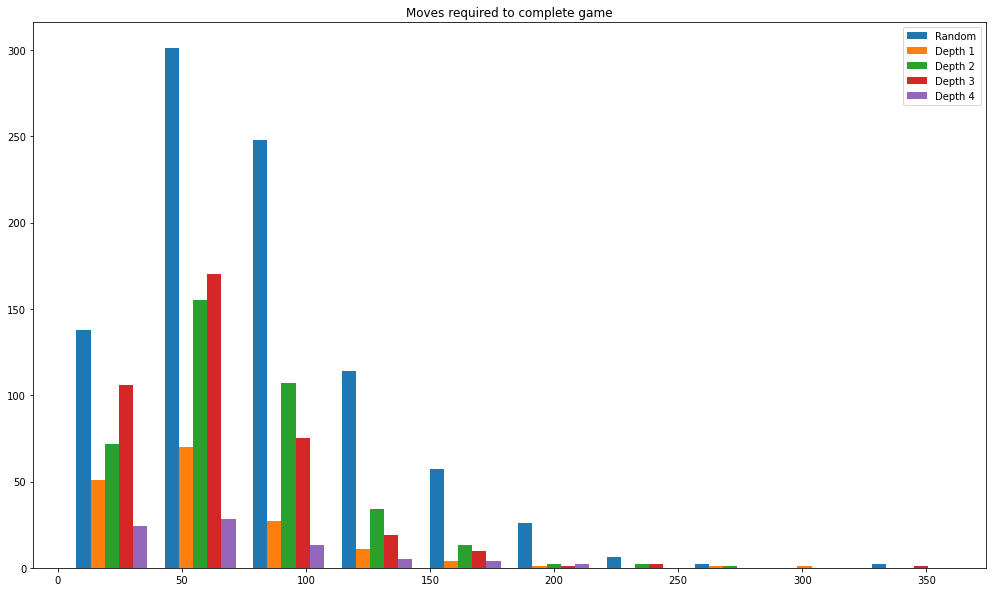

In [30]:
# how many moves before white wins?
wwdr = all2[(all2['winner'] == 'white') & (all2['white_player_type'] == 'RANDOM')]
wwd1 = all2[(all2['winner'] == 'white') & (all2['white_search_depth'] == 1)]
wwd2 = all2[(all2['winner'] == 'white') & (all2['white_search_depth'] == 2)]
wwd3 = all2[(all2['winner'] == 'white') & (all2['white_search_depth'] == 3)]
wwd4 = all2[(all2['winner'] == 'white') & (all2['white_search_depth'] == 4)]

n_bins = 10
x = [wwdr['turn_number'], wwd1['turn_number'], wwd2['turn_number'], wwd3['turn_number'], wwd4['turn_number']]

px = 1/plt.rcParams['figure.dpi']  # pixel in inches
fig, ax0 = plt.subplots(figsize=(1000*px, 600*px))

colors = ['Random', 'Depth 1', 'Depth 2', 'Depth 3', 'Depth 4']
ax0.hist(x, n_bins, histtype='bar', label=colors)
ax0.legend(prop={'size': 10})
ax0.set_title('Moves required to complete game')

fig.tight_layout()
plt.show()

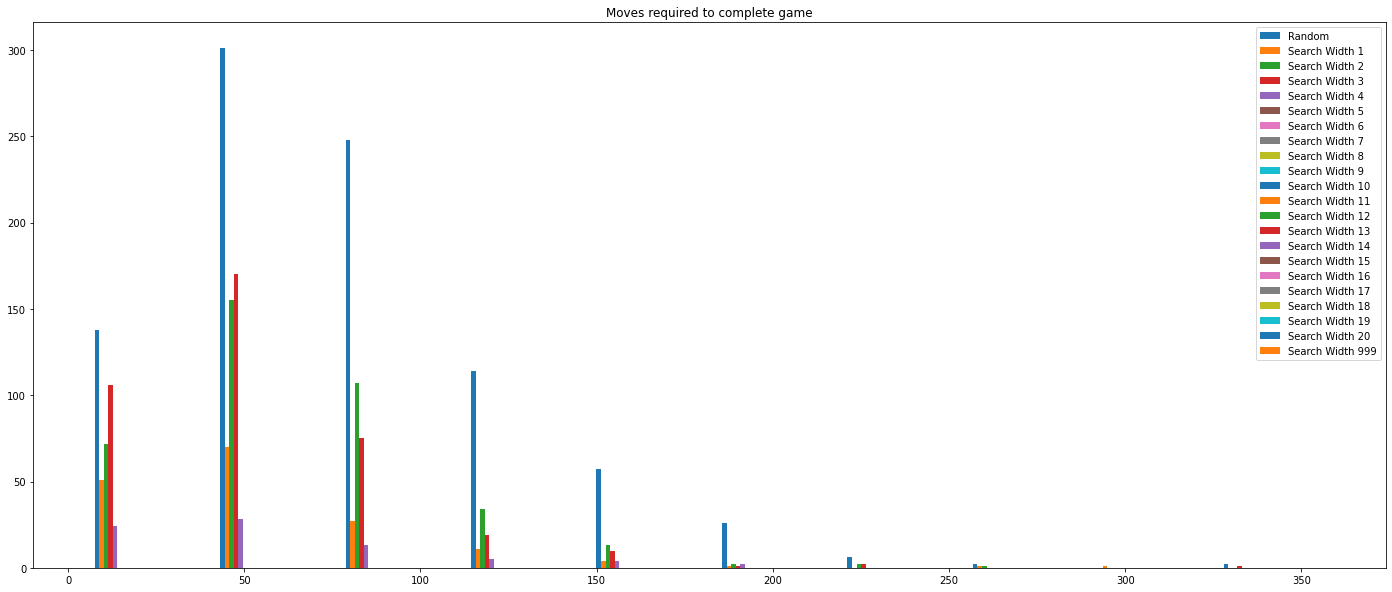

In [31]:
# how many moves before white wins?
items = []
labels = []
wwwr = all2[(all2['winner'] == 'white') & (all2['white_player_type'] == 'RANDOM')]
items.append(wwwr['turn_number'])
labels.append("Random")

all2 = all2[(all2['white_player_type'] == 'SEARCH')]

for width in all2['white_search_width'].unique():
    width = int(width)
    items.append(all2[(all2['winner'] == 'white') & (all2['white_search_depth'] == width)]['turn_number'])
    labels.append(f'Search Width {width}')

n_bins = 10
x = items

px = 1 / plt.rcParams['figure.dpi']  # pixel in inches
fig, ax0 = plt.subplots(figsize=(1400 * px, 600 * px))

ax0.hist(x, n_bins, histtype='bar', label=labels)
ax0.legend(prop={'size': 10})
ax0.set_title('Moves required to complete game')

fig.tight_layout()
plt.show()

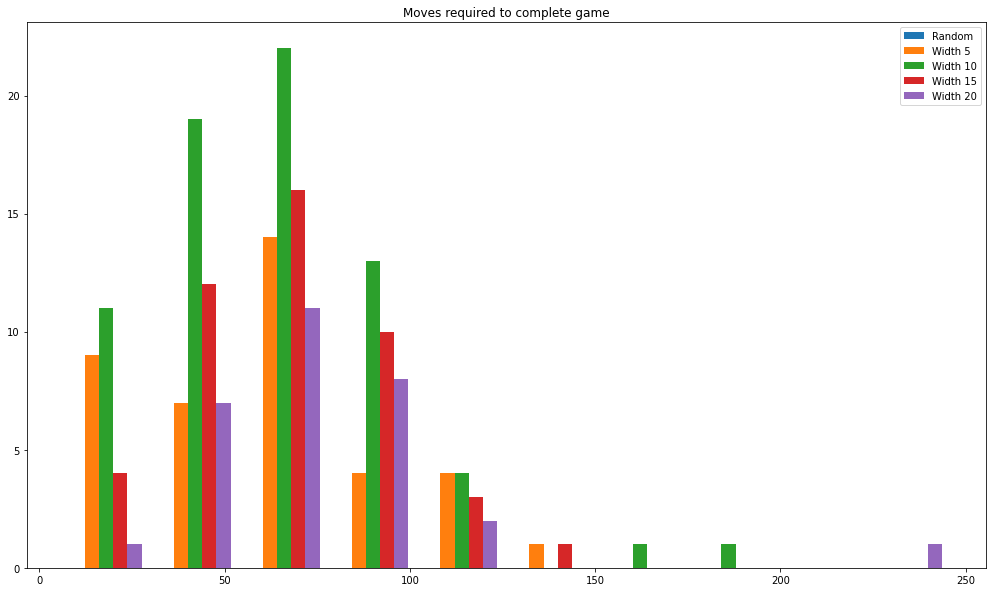

In [32]:
# how many moves before white wins?
wwwr = all2[(all2['winner'] == 'white') & (all2['white_player_type'] == 'RANDOM')]
www5 = all2[(all2['winner'] == 'white') & (all2['white_search_width'] == 5)]
www10 = all2[(all2['winner'] == 'white') & (all2['white_search_width'] == 10)]
www15 = all2[(all2['winner'] == 'white') & (all2['white_search_width'] == 15)]
www20 = all2[(all2['winner'] == 'white') & (all2['white_search_width'] == 20)]

n_bins = 10
x = [wwwr['turn_number'], www5['turn_number'], www10['turn_number'], www15['turn_number'], www20['turn_number']]

px = 1/plt.rcParams['figure.dpi']  # pixel in inches
fig, ax0 = plt.subplots(figsize=(1000*px, 600*px))

colors = ['Random', 'Width 5', 'Width 10', 'Width 15', 'Width 20']
ax0.hist(x, n_bins, histtype='bar', label=colors)
ax0.legend(prop={'size': 10})
ax0.set_title('Moves required to complete game')

fig.tight_layout()
plt.show()

In [87]:
# reset
all2 = pd.read_json('mega-chess-4.json')
all2 = all2.drop(['game','fen', 'game_start_time', 'game_end_time'], axis=1)
all2['white_player_type'] = all2['white_player_type'].astype("category")
all2['black_player_type'] = all2['black_player_type'].astype("category")
all2['game_state'] = all2['game_state'].astype("category")
all2['outcome'] = all2['outcome'].astype("category")
all2['winner'] = all2['winner'].astype("category")

# unfinished = all2[(all2['game_state'] != 'game over')]
all2 = all2[(all2['game_state'] == 'game over')]



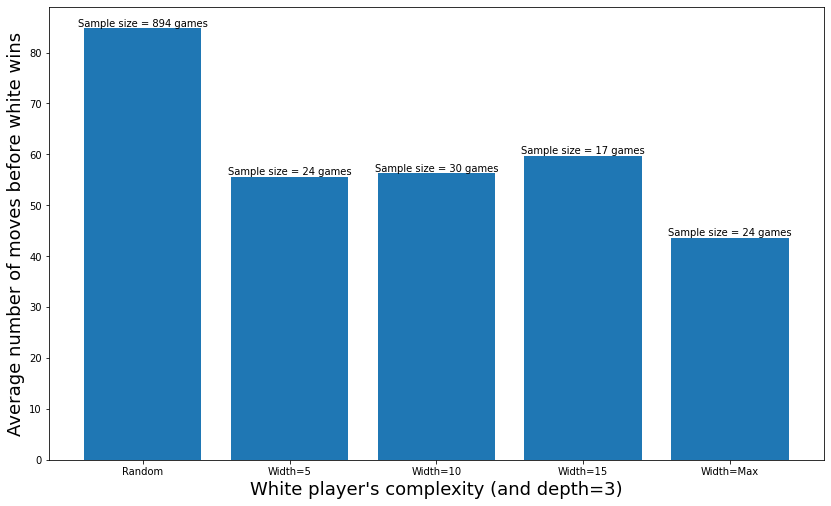

In [88]:
# how many moves before white wins?
wwwr = all2[(all2['winner'] == 'white') & (all2['white_player_type'] == 'RANDOM')]
www5 = all2[(all2['winner'] == 'white') & (all2['white_search_width'] == 5) & (all2['white_search_depth'] == 3)]
www10 = all2[(all2['winner'] == 'white') & (all2['white_search_width'] == 10) & (all2['white_search_depth'] == 3)]
www15 = all2[(all2['winner'] == 'white') & (all2['white_search_width'] == 15) & (all2['white_search_depth'] == 3)]
www999 = all2[(all2['winner'] == 'white') & (all2['white_search_width'] == 999) & (all2['white_search_depth'] == 3)]


pool_size = []

moves_sum = 0
for moves in wwwr['turn_number']:
    moves_sum += moves
avg_moves_rand = moves_sum / len(wwwr)
pool_size.append(f'Sample size = {len(wwwr)} games')

moves_sum = 0
for moves in www5['turn_number']:
    moves_sum += moves
avg_moves_5 = moves_sum / len(www5)
pool_size.append(f'Sample size = {len(www5)} games')

moves_sum = 0
for moves in www10['turn_number']:
    moves_sum += moves
avg_moves_10 = moves_sum / len(www10)
pool_size.append(f'Sample size = {len(www10)} games')

moves_sum = 0
for moves in www15['turn_number']:
    moves_sum += moves
avg_moves_15 = moves_sum / len(www15)
pool_size.append(f'Sample size = {len(www15)} games')

moves_sum = 0
for moves in www999['turn_number']:
    moves_sum += moves
avg_moves_999 = moves_sum / len(www999)
pool_size.append(f'Sample size = {len(www999)} games')


px = 1 / plt.rcParams['figure.dpi']  # pixel in inches
fig, ax = plt.subplots(figsize=(1000 * px, 600 * px))
# fig = plt.figure()
# ax = fig.add_axes([0,0,1,1])
labels = ['Random', 'Width=5', 'Width=10', 'Width=15', 'Width=Max']
values = [avg_moves_rand, avg_moves_5, avg_moves_10, avg_moves_15, avg_moves_999]
rects = ax.bar(labels, values)
ax.bar_label(rects, pool_size, label_type='edge')
ax.set_ylabel('Average number of moves before white wins', fontsize=18)
ax.set_xlabel('White player\'s complexity (and depth=3)', fontsize=18)
plt.show()

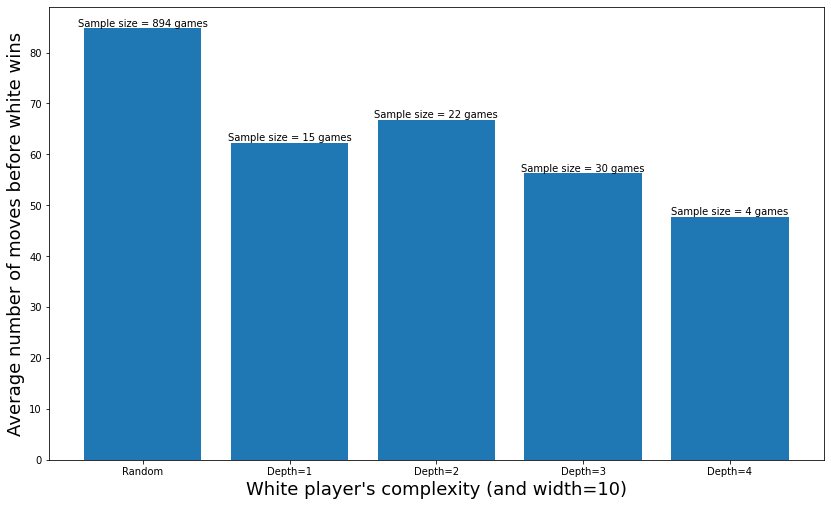

In [89]:
# how many moves before white wins?
wwdr = all2[(all2['winner'] == 'white') & (all2['white_player_type'] == 'RANDOM')]
wwd1 = all2[(all2['winner'] == 'white') & (all2['white_search_width'] == 10) & (all2['white_search_depth'] == 1)]
wwd2 = all2[(all2['winner'] == 'white') & (all2['white_search_width'] == 10) & (all2['white_search_depth'] == 2)]
wwd3 = all2[(all2['winner'] == 'white') & (all2['white_search_width'] == 10) & (all2['white_search_depth'] == 3)]
wwd4 = all2[(all2['winner'] == 'white') & (all2['white_search_width'] == 10) & (all2['white_search_depth'] == 4)]


pool_size = []

moves_sum = 0
for moves in wwdr['turn_number']:
    moves_sum += moves
avg_moves_rand = moves_sum / len(wwdr)
pool_size.append(f'Sample size = {len(wwdr)} games')

moves_sum = 0
for moves in wwd1['turn_number']:
    moves_sum += moves
avg_moves_1 = moves_sum / len(wwd1)
pool_size.append(f'Sample size = {len(wwd1)} games')

moves_sum = 0
for moves in wwd2['turn_number']:
    moves_sum += moves
avg_moves_2 = moves_sum / len(wwd2)
pool_size.append(f'Sample size = {len(wwd2)} games')

moves_sum = 0
for moves in wwd3['turn_number']:
    moves_sum += moves
avg_moves_3 = moves_sum / len(wwd3)
pool_size.append(f'Sample size = {len(wwd3)} games')

moves_sum = 0
for moves in wwd4['turn_number']:
    moves_sum += moves
avg_moves_4 = moves_sum / len(wwd4)
pool_size.append(f'Sample size = {len(wwd4)} games')


px = 1 / plt.rcParams['figure.dpi']  # pixel in inches
fig, ax = plt.subplots(figsize=(1000 * px, 600 * px))
# fig = plt.figure()
# ax = fig.add_axes([0,0,1,1])
labels = ['Random', 'Depth=1', 'Depth=2', 'Depth=3', 'Depth=4']
values = [avg_moves_rand, avg_moves_1, avg_moves_2, avg_moves_3, avg_moves_4]
rects = ax.bar(labels, values)
ax.bar_label(rects, pool_size, label_type='edge')
ax.set_ylabel('Average number of moves before white wins', fontsize=18)
ax.set_xlabel('White player\'s complexity (and width=10)', fontsize=18)
plt.show()

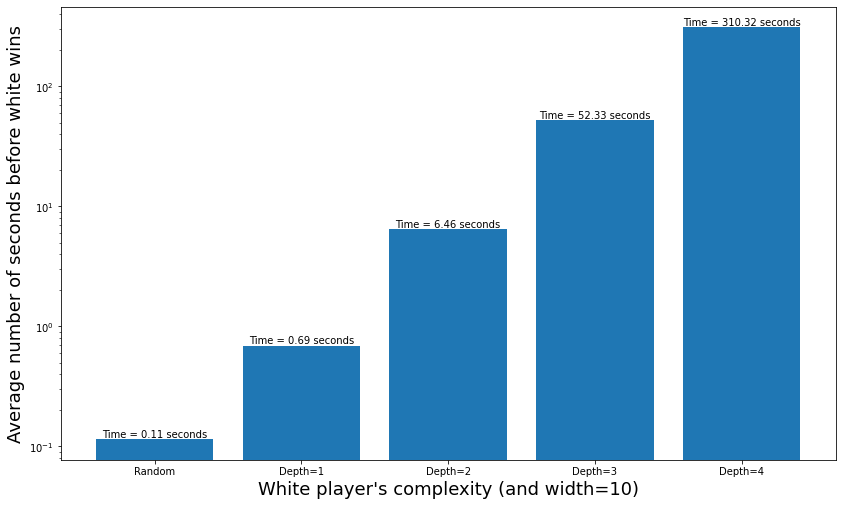

In [90]:
# how many moves before white wins?
wwdr = all2[(all2['winner'] == 'white') & (all2['white_player_type'] == 'RANDOM')]
wwd1 = all2[(all2['winner'] == 'white') & (all2['white_search_width'] == 10) & (all2['white_search_depth'] == 1)]
wwd2 = all2[(all2['winner'] == 'white') & (all2['white_search_width'] == 10) & (all2['white_search_depth'] == 2)]
wwd3 = all2[(all2['winner'] == 'white') & (all2['white_search_width'] == 10) & (all2['white_search_depth'] == 3)]
wwd4 = all2[(all2['winner'] == 'white') & (all2['white_search_width'] == 10) & (all2['white_search_depth'] == 4)]


pool_size = []

moves_sum = 0
for moves in wwdr['game_time_seconds']:
    moves_sum += moves
avg_moves_rand = moves_sum / len(wwdr)
pool_size.append(f'Time = {avg_moves_rand:.2f} seconds')

moves_sum = 0
for moves in wwd1['game_time_seconds']:
    moves_sum += moves
avg_moves_1 = moves_sum / len(wwd1)
pool_size.append(f'Time = {avg_moves_1:.2f} seconds')

moves_sum = 0
for moves in wwd2['game_time_seconds']:
    moves_sum += moves
avg_moves_2 = moves_sum / len(wwd2)
pool_size.append(f'Time = {avg_moves_2:.2f} seconds')

moves_sum = 0
for moves in wwd3['game_time_seconds']:
    moves_sum += moves
avg_moves_3 = moves_sum / len(wwd3)
pool_size.append(f'Time = {avg_moves_3:.2f} seconds')

moves_sum = 0
for moves in wwd4['game_time_seconds']:
    moves_sum += moves
avg_moves_4 = moves_sum / len(wwd4)
pool_size.append(f'Time = {avg_moves_4:.2f} seconds')


px = 1 / plt.rcParams['figure.dpi']  # pixel in inches
fig, ax = plt.subplots(figsize=(1000 * px, 600 * px))
# fig = plt.figure()
# ax = fig.add_axes([0,0,1,1])
labels = ['Random', 'Depth=1', 'Depth=2', 'Depth=3', 'Depth=4']
values = [avg_moves_rand, avg_moves_1, avg_moves_2, avg_moves_3, avg_moves_4]
rects = ax.bar(labels, values)
ax.bar_label(rects, pool_size, label_type='edge')
ax.set_ylabel('Average number of seconds before white wins', fontsize=18)
ax.set_xlabel('White player\'s complexity (and width=10)', fontsize=18)
ax.set_yscale('log')
plt.show()

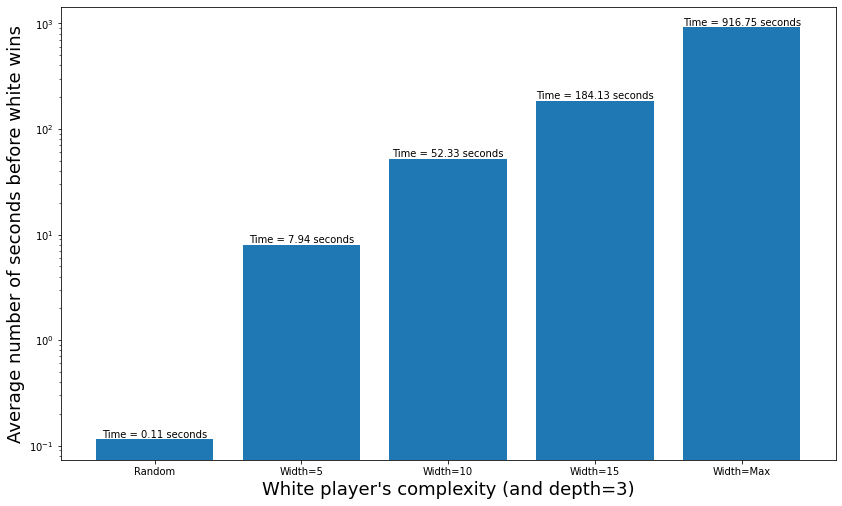

In [91]:
# how many moves before white wins?
wwwr = all2[(all2['winner'] == 'white') & (all2['white_player_type'] == 'RANDOM')]
www5 = all2[(all2['winner'] == 'white') & (all2['white_search_width'] == 5) & (all2['white_search_depth'] == 3)]
www10 = all2[(all2['winner'] == 'white') & (all2['white_search_width'] == 10) & (all2['white_search_depth'] == 3)]
www15 = all2[(all2['winner'] == 'white') & (all2['white_search_width'] == 15) & (all2['white_search_depth'] == 3)]
www999 = all2[(all2['winner'] == 'white') & (all2['white_search_width'] == 999) & (all2['white_search_depth'] == 3)]


pool_size = []

moves_sum = 0
for moves in wwwr['game_time_seconds']:
    moves_sum += moves
avg_moves_rand = moves_sum / len(wwwr)
pool_size.append(f'Time = {avg_moves_rand:.2f} seconds')

moves_sum = 0
for moves in www5['game_time_seconds']:
    moves_sum += moves
avg_moves_5 = moves_sum / len(www5)
pool_size.append(f'Time = {avg_moves_5:.2f} seconds')

moves_sum = 0
for moves in www10['game_time_seconds']:
    moves_sum += moves
avg_moves_10 = moves_sum / len(www10)
pool_size.append(f'Time = {avg_moves_10:.2f} seconds')

moves_sum = 0
for moves in www15['game_time_seconds']:
    moves_sum += moves
avg_moves_15 = moves_sum / len(www15)
pool_size.append(f'Time = {avg_moves_15:.2f} seconds')

moves_sum = 0
for moves in www999['game_time_seconds']:
    moves_sum += moves
avg_moves_999 = moves_sum / len(www999)
pool_size.append(f'Time = {avg_moves_999:.2f} seconds')


px = 1 / plt.rcParams['figure.dpi']  # pixel in inches
fig, ax = plt.subplots(figsize=(1000 * px, 600 * px))
# fig = plt.figure()
# ax = fig.add_axes([0,0,1,1])
labels = ['Random', 'Width=5', 'Width=10', 'Width=15', 'Width=Max']
values = [avg_moves_rand, avg_moves_5, avg_moves_10, avg_moves_15, avg_moves_999]
rects = ax.bar(labels, values)
ax.bar_label(rects, pool_size, label_type='edge')
ax.set_ylabel('Average number of seconds before white wins', fontsize=18)
ax.set_xlabel('White player\'s complexity (and depth=3)', fontsize=18)
ax.set_yscale('log')
plt.show()

# Strength vs runtime

In [102]:
# reset
all2 = pd.read_json('mega-chess-5.json')
all2 = all2.drop(['game','fen', 'game_start_time', 'game_end_time'], axis=1)
all2['white_player_type'] = all2['white_player_type'].astype("category")
all2['black_player_type'] = all2['black_player_type'].astype("category")
all2['game_state'] = all2['game_state'].astype("category")
all2['outcome'] = all2['outcome'].astype("category")
all2['winner'] = all2['winner'].astype("category")

all2 = all2[(all2['game_state'] == 'game over')]

svr = all2[(all2['white_player_type'] == 'SEARCH')]
rvr = all2[(all2['white_player_type'] == 'RANDOM')]

In [103]:
# drop junk
svr = svr.drop(svr[svr.white_search_width == 1].index)
svr = svr.drop(svr[svr.white_search_width == 2].index)
svr = svr.drop(svr[svr.white_search_width == 3].index)
svr = svr.drop(svr[svr.white_search_width == 4].index)
svr = svr.drop(svr[svr.white_search_width == 6].index)
svr = svr.drop(svr[svr.white_search_width == 7].index)
svr = svr.drop(svr[svr.white_search_width == 8].index)
svr = svr.drop(svr[svr.white_search_width == 9].index)
svr = svr.drop(svr[svr.white_search_width == 11].index)
svr = svr.drop(svr[svr.white_search_width == 12].index)
svr = svr.drop(svr[svr.white_search_width == 13].index)
svr = svr.drop(svr[svr.white_search_width == 14].index)
svr = svr.drop(svr[svr.white_search_width == 16].index)
svr = svr.drop(svr[svr.white_search_width == 17].index)
svr = svr.drop(svr[svr.white_search_width == 18].index)
svr = svr.drop(svr[svr.white_search_width == 19].index)


In [104]:
len(all2[(all2['white_search_depth'] == 1) & (all2['white_search_width'] == 999)])

272

In [105]:
labels = []
white_win_rates = []
draw_rates = []
black_win_rates = []

pool_size = []

white_wins_rvr = rvr[(rvr['winner'] == 'white')]
draws_rvr = rvr[(rvr['winner'] == 'draw')]
black_wins_rvr = rvr[(rvr['winner'] == 'black')]
white_wins_rvr_rate = len(white_wins_rvr) / len(rvr)
draws_rvr_rate = len(draws_rvr) / len(rvr)
black_wins_rvr_rate = len(black_wins_rvr) / len(rvr)
labels.append('RvR')
white_win_rates.append(100*white_wins_rvr_rate)
draw_rates.append(100*draws_rvr_rate)
black_win_rates = [100*black_wins_rvr_rate]

moves_sum = 0
for moves in rvr['game_time_seconds']:
    moves_sum += moves
avg_runtime_rvr = moves_sum / len(rvr)

pool_size.append(f'Pool = {len(rvr)}\nAvg run = {avg_runtime_rvr:.2f} sec')


# in SVR
for depth in svr['white_search_depth'].unique():
  depth = int(depth)
  svr_d = svr[(svr['white_search_depth'] == depth)]
  for width in svr_d['white_search_width'].unique():
    width = int(width)
    svr_d_w = svr_d[(svr_d['white_search_width'] == width)]

    moves_sum = 0
    for moves in svr_d_w['game_time_seconds']:
      moves_sum += moves
    avg_runtime_svr_d_w = moves_sum / len(svr_d_w)

    pool_size.append(f'Pool = {len(svr_d_w)}\nAvg run = {avg_runtime_svr_d_w:.2f} sec')

    white_wins_svr_d_w = svr_d_w[(svr_d_w['winner'] == 'white')]
    draws_svr_d_w = svr_d_w[(svr_d_w['winner'] == 'draw')]
    black_wins_svr_d_w = svr_d_w[(svr_d_w['winner'] == 'black')]
    white_wins_svr_d_w_rate = len(white_wins_svr_d_w) / len(svr_d_w)
    draws_svr_d_w_rate = len(draws_svr_d_w) / len(svr_d_w)
    black_wins_svr_d_w_rate = len(black_wins_svr_d_w) / len(svr_d_w)
    labels.append(f'SvR d{depth} w{width}')
    white_win_rates.append(100*white_wins_svr_d_w_rate)
    draw_rates.append(100*draws_svr_d_w_rate)
    black_win_rates.append(100*black_wins_svr_d_w_rate)

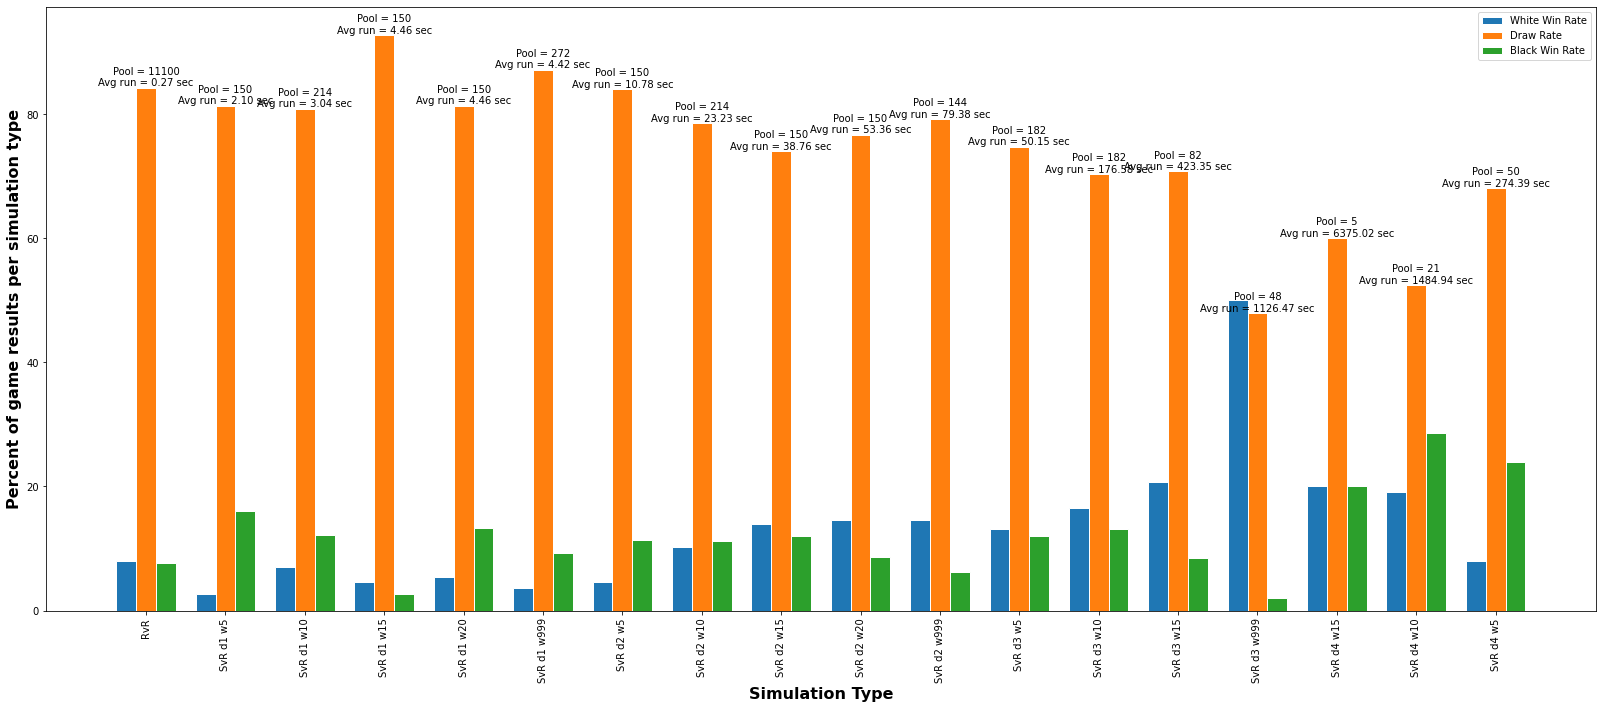

In [106]:
px = 1/plt.rcParams['figure.dpi']  # pixel in inches
fig, ax = plt.subplots(figsize=(2000*px, 800*px))

# set width of bars
barWidth = 0.25
 
# set heights of bars
bars1 = white_win_rates
bars2 = draw_rates
bars3 = black_win_rates
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
rects1 = plt.bar(r1, bars1, width=barWidth, edgecolor='white', label='White Win Rate')
rects2 = plt.bar(r2, bars2, width=barWidth, edgecolor='white', label='Draw Rate')
rects3 = plt.bar(r3, bars3, width=barWidth, edgecolor='white', label='Black Win Rate')
 
# Add xticks on the middle of the group bars
ax.set_xlabel('Simulation Type', fontweight='bold', fontsize=16)
plt.xticks([r + barWidth for r in range(len(bars1))], labels, rotation=90)
ax.set_ylabel('Percent of game results per simulation type', fontweight='bold', fontsize=16)

ax.bar_label(rects2, pool_size, label_type='edge')

# Create legend & Show graphic
plt.legend()
plt.show()

# labels = ['Random', 'Width=5', 'Width=10', 'Width=15', 'Width=Max']
# values = [avg_moves_rand, avg_moves_5, avg_moves_10, avg_moves_15, avg_moves_999]
# rects = ax.bar(labels, values)
# ax.bar_label(rects, pool_size, label_type='edge')
# ax.set_ylabel('Average number of seconds before white wins', fontsize=18)
# ax.set_xlabel('White player\'s complexity (and depth=3)', fontsize=18)
# ax.set_yscale('log')
# plt.show()
